In [132]:
from sinexpDL import *
from pathlib import Path
runnum = 0

In [133]:
import numpy as np
import math
import sys
import os
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from datetime import date, datetime
cuda = True if torch.cuda.is_available() else False
device = "cuda:0" if cuda else "cpu"
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

class OPT(object):
    def __init__(self,) -> None:
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 1
        self.img_size = 64
        self.channels = 1
        self.img_shape = (1, self.img_size, self.img_size)
opt = OPT()


In [134]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Tanh())
            return layers
        
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img


In [135]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [136]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [137]:
# Loss weight for gradient penalty
lambda_gp = 10
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    # print(alpha.shape,real_samples.shape,fake_samples.shape)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [138]:
pstart = 1
pend = 2
ds = specGds("cuda:0", pstart, pend)
dataloader = DataLoader(ds,
    batch_size=opt.batch_size,
    shuffle=True,
    drop_last=False,
)

def noise_fn(x = opt.batch_size):
    return Variable(torch.abs(torch.normal(mean = (pstart+pend)/2, std = (pend - pstart)/8, size = (x,opt.latent_dim),device=device)))


self.pspace.shape = (1000,) | self.__len__() = 1000


In [139]:
noise_fn()

tensor([[1.6756],
        [1.4099],
        [1.5732],
        [1.3834],
        [1.5412],
        [1.6787],
        [1.2749],
        [1.2631],
        [1.4138],
        [1.3804],
        [1.4081],
        [1.4839],
        [1.3790],
        [1.4728],
        [1.4889],
        [1.5391],
        [1.4601],
        [1.5387],
        [1.3935],
        [1.4564],
        [1.4868],
        [1.4937],
        [1.5636],
        [1.4544],
        [1.5385],
        [1.3133],
        [1.3707],
        [1.4917],
        [1.3235],
        [1.5371],
        [1.5235],
        [1.5091],
        [1.3788],
        [1.3329],
        [1.3090],
        [1.3775],
        [1.4273],
        [1.4013],
        [1.4453],
        [1.5064],
        [1.5726],
        [1.5818],
        [1.4838],
        [1.4189],
        [1.3207],
        [1.5431],
        [1.4150],
        [1.6608],
        [1.7401],
        [1.2880],
        [1.4677],
        [1.3979],
        [1.3426],
        [1.5283],
        [1.5338],
        [1

In [140]:
batches_done = 0
timestarted = datetime.now()
timestarted = str(timestarted.hour) + " " + str(timestarted.minute) + " " +  str(timestarted.second)
dloss = []
gloss = []
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = noise_fn(imgs.shape[0])

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # -----------------
        #  Train Generator
        # -----------------

        # Generate a batch of images
        fake_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        # Train on fake images
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        print(
            f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.5}] [G loss: {g_loss.item():.5}] {' '*5}", flush=True, end = "\r"
        )
        dloss.append(d_loss.item())
        gloss.append(g_loss.item())
        if i%16 == 0:
            print()

        if batches_done % 5 == 0:
            path = Path(f"./images/{date.today()}/{timestarted}/{runnum}/")
            path.mkdir(parents=True, exist_ok=True)
            save_image(fake_imgs.data[:], f"images/{date.today().isoformat()}/{timestarted}/{runnum}/{batches_done}.png", nrow=8, normalize=True)
        
        batches_done += 1

[Epoch 0/200] [Batch 0/16] [D loss: 8.2455] [G loss: -0.047315]      
[Epoch 1/200] [Batch 0/16] [D loss: 5.201] [G loss: -4.3787]         
[Epoch 2/200] [Batch 0/16] [D loss: -7.197] [G loss: 10.463]        
[Epoch 3/200] [Batch 0/16] [D loss: -0.18028] [G loss: 0.4387]        
[Epoch 4/200] [Batch 0/16] [D loss: 1.3955] [G loss: -1.1239]         
[Epoch 5/200] [Batch 0/16] [D loss: 2.3781] [G loss: -1.7443]       


KeyboardInterrupt: 

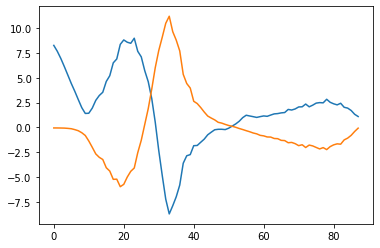

In [141]:
plt.plot(dloss)
plt.plot(gloss)
plt.show()

In [146]:
z = noise_fn()
gen_imgs = generator(z)

Input to Generator: tensor([1.5047], device='cuda:0')


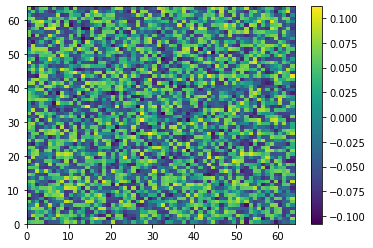

Input to Generator: tensor([1.2974], device='cuda:0')


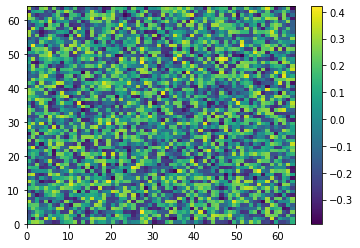

Input to Generator: tensor([1.5528], device='cuda:0')


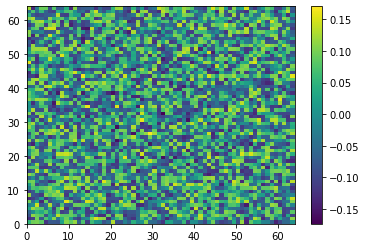

Input to Generator: tensor([1.3217], device='cuda:0')


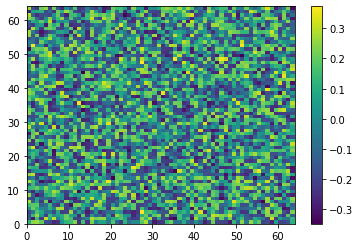

Input to Generator: tensor([1.5226], device='cuda:0')


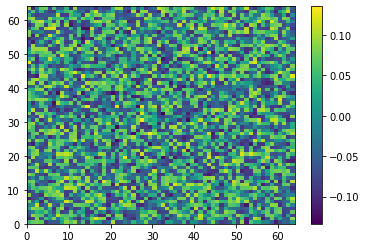

Input to Generator: tensor([1.3772], device='cuda:0')


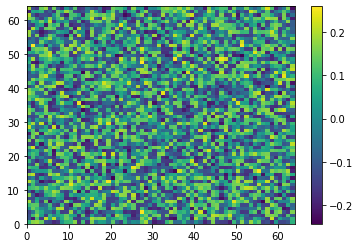

Input to Generator: tensor([1.4385], device='cuda:0')


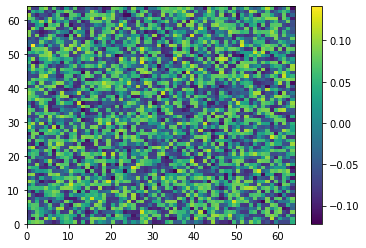

Input to Generator: tensor([1.4678], device='cuda:0')


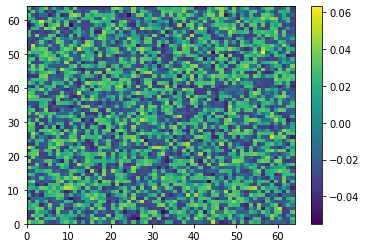

Input to Generator: tensor([1.5691], device='cuda:0')


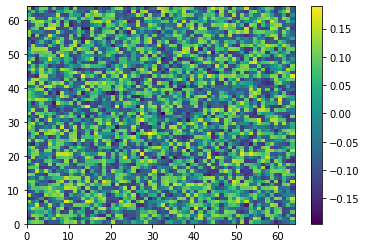

Input to Generator: tensor([1.3278], device='cuda:0')


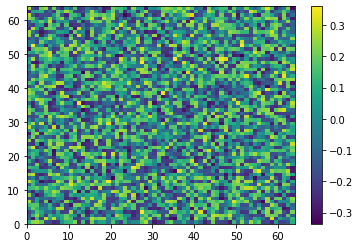

Input to Generator: tensor([1.5292], device='cuda:0')


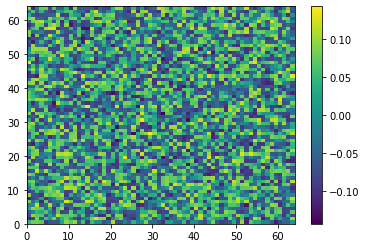

Input to Generator: tensor([1.4695], device='cuda:0')


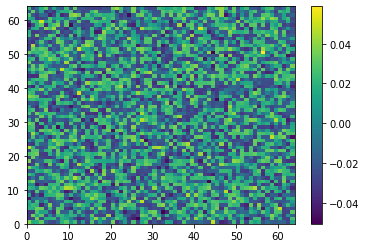

Input to Generator: tensor([1.5345], device='cuda:0')


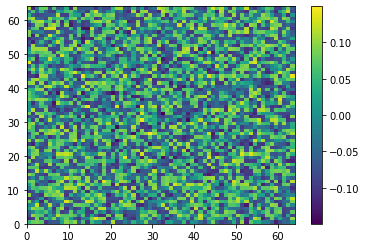

Input to Generator: tensor([1.4418], device='cuda:0')


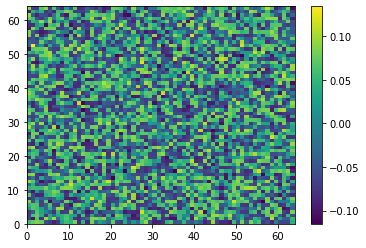

Input to Generator: tensor([1.4319], device='cuda:0')


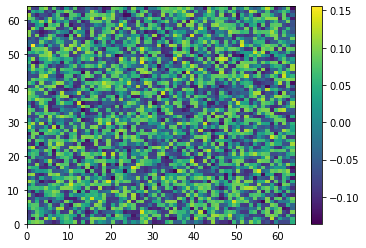

Input to Generator: tensor([1.3853], device='cuda:0')


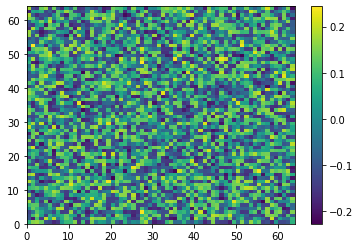

Input to Generator: tensor([1.4211], device='cuda:0')


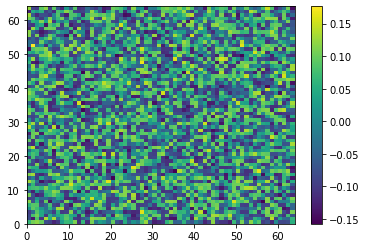

Input to Generator: tensor([1.4072], device='cuda:0')


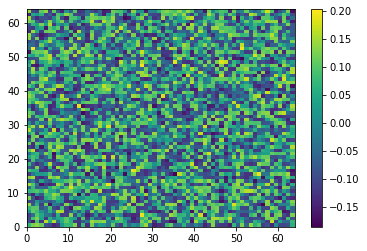

Input to Generator: tensor([1.3392], device='cuda:0')


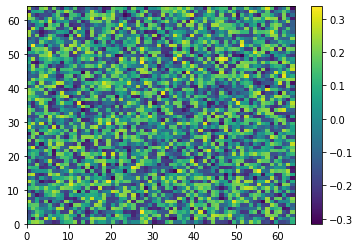

Input to Generator: tensor([1.5318], device='cuda:0')


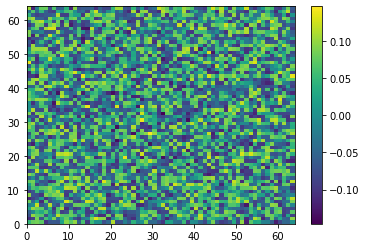

Input to Generator: tensor([1.3676], device='cuda:0')


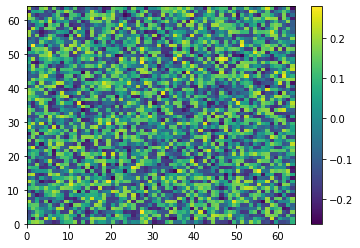

Input to Generator: tensor([1.5821], device='cuda:0')


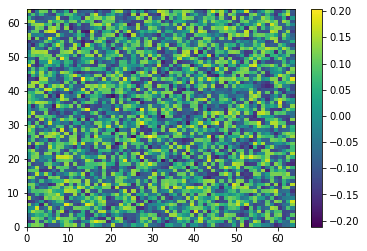

Input to Generator: tensor([1.2984], device='cuda:0')


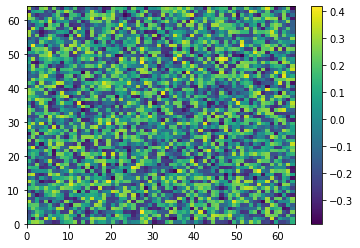

Input to Generator: tensor([1.5931], device='cuda:0')


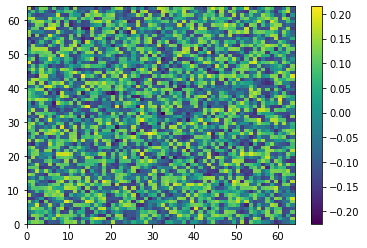

Input to Generator: tensor([1.5700], device='cuda:0')


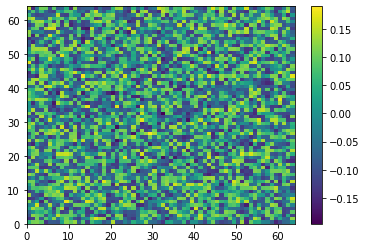

Input to Generator: tensor([1.5136], device='cuda:0')


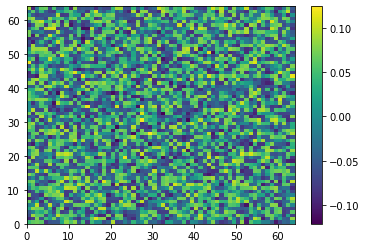

Input to Generator: tensor([1.4782], device='cuda:0')


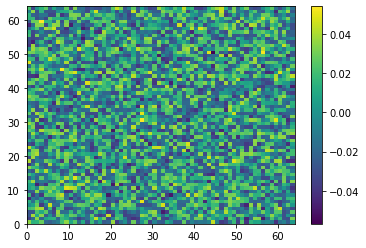

Input to Generator: tensor([1.4663], device='cuda:0')


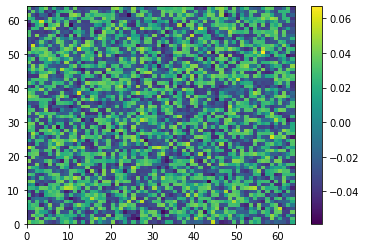

Input to Generator: tensor([1.4905], device='cuda:0')


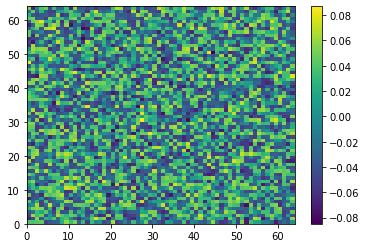

Input to Generator: tensor([1.4364], device='cuda:0')


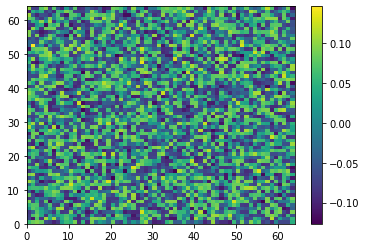

Input to Generator: tensor([1.3900], device='cuda:0')


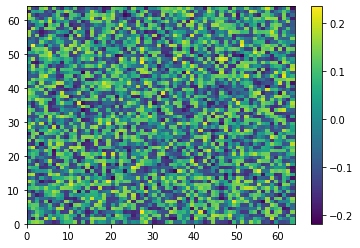

Input to Generator: tensor([1.4514], device='cuda:0')


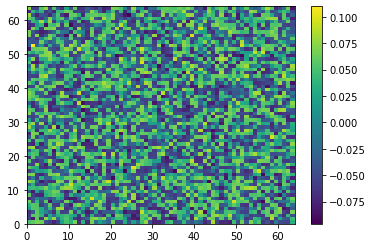

Input to Generator: tensor([1.3224], device='cuda:0')


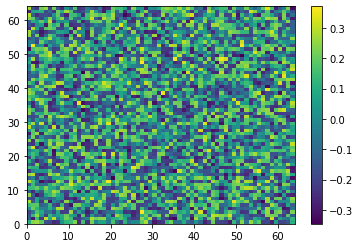

Input to Generator: tensor([1.4641], device='cuda:0')


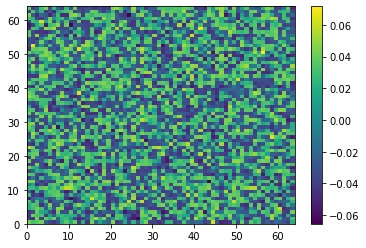

Input to Generator: tensor([1.8024], device='cuda:0')


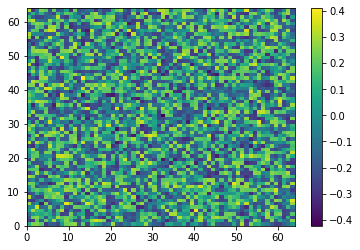

Input to Generator: tensor([1.4166], device='cuda:0')


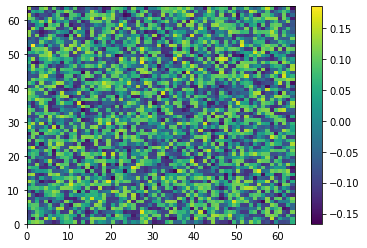

Input to Generator: tensor([1.5708], device='cuda:0')


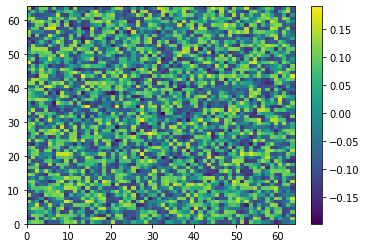

Input to Generator: tensor([1.6103], device='cuda:0')


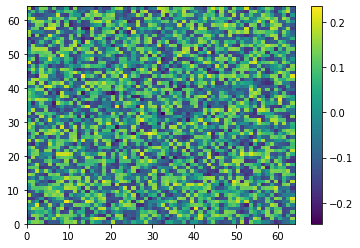

Input to Generator: tensor([1.4166], device='cuda:0')


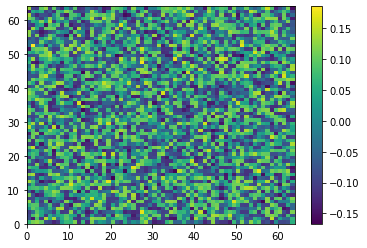

Input to Generator: tensor([1.6326], device='cuda:0')


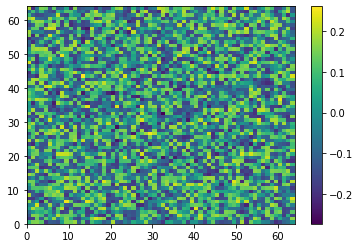

Input to Generator: tensor([1.7630], device='cuda:0')


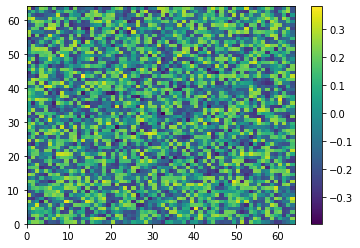

Input to Generator: tensor([1.5015], device='cuda:0')


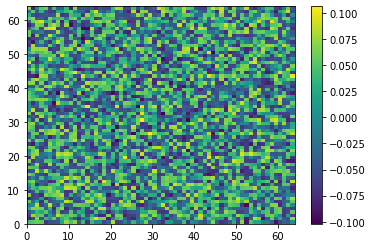

Input to Generator: tensor([1.4482], device='cuda:0')


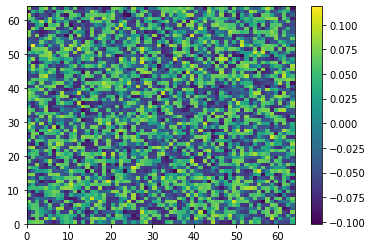

Input to Generator: tensor([1.2841], device='cuda:0')


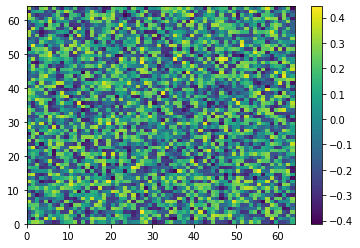

Input to Generator: tensor([1.6455], device='cuda:0')


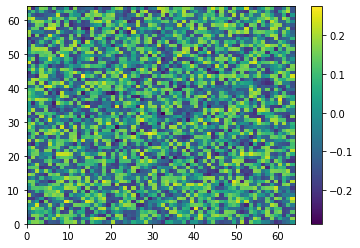

Input to Generator: tensor([1.4976], device='cuda:0')


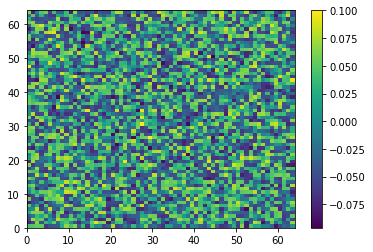

Input to Generator: tensor([1.3611], device='cuda:0')


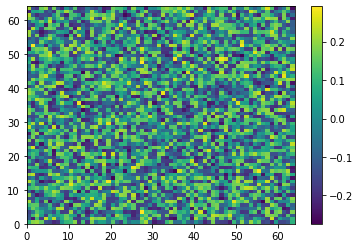

Input to Generator: tensor([1.5114], device='cuda:0')


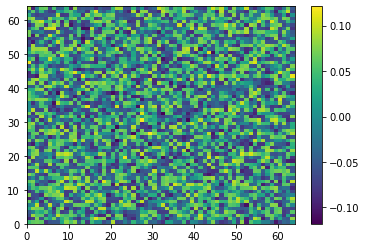

Input to Generator: tensor([1.5335], device='cuda:0')


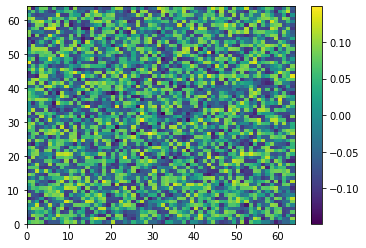

Input to Generator: tensor([1.3997], device='cuda:0')


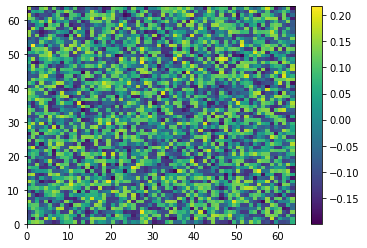

Input to Generator: tensor([1.5273], device='cuda:0')


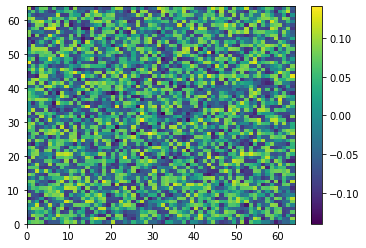

Input to Generator: tensor([1.4168], device='cuda:0')


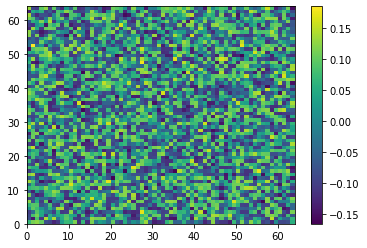

Input to Generator: tensor([1.4615], device='cuda:0')


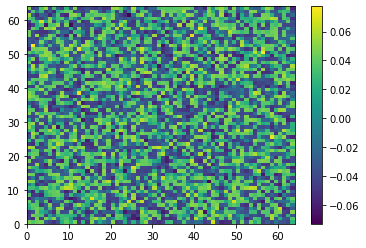

Input to Generator: tensor([1.5103], device='cuda:0')


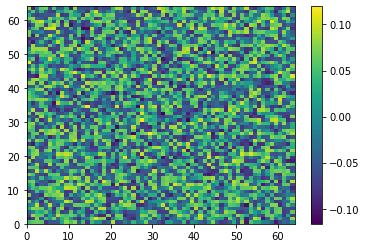

Input to Generator: tensor([1.5077], device='cuda:0')


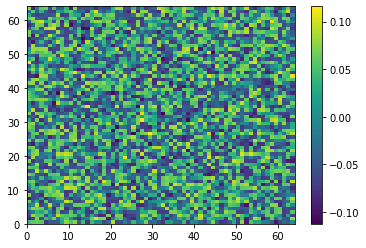

Input to Generator: tensor([1.4542], device='cuda:0')


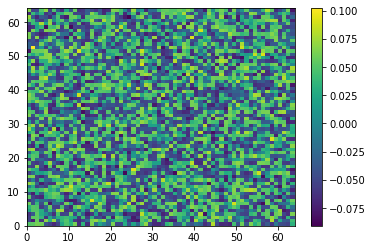

Input to Generator: tensor([1.4892], device='cuda:0')


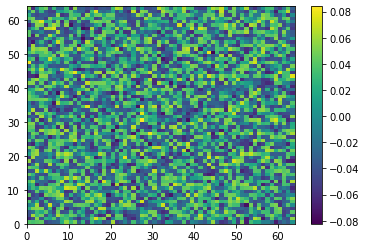

Input to Generator: tensor([1.5623], device='cuda:0')


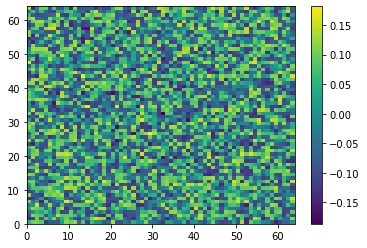

Input to Generator: tensor([1.6222], device='cuda:0')


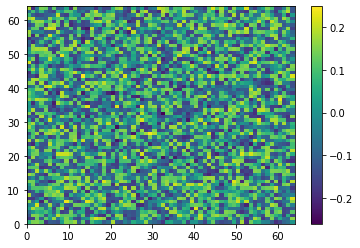

Input to Generator: tensor([1.2972], device='cuda:0')


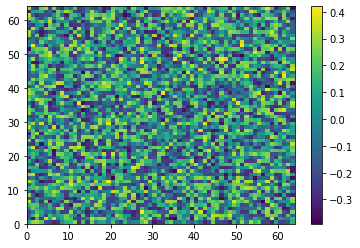

Input to Generator: tensor([1.3630], device='cuda:0')


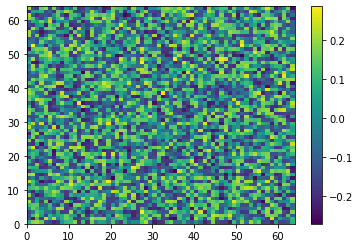

Input to Generator: tensor([1.6688], device='cuda:0')


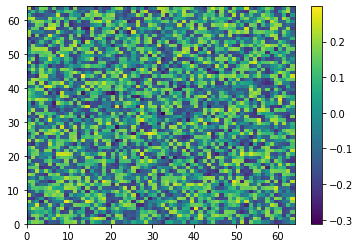

Input to Generator: tensor([1.6470], device='cuda:0')


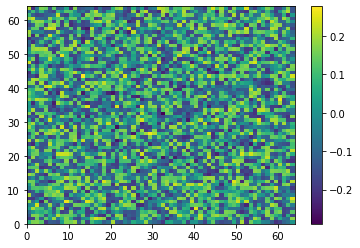

Input to Generator: tensor([1.4903], device='cuda:0')


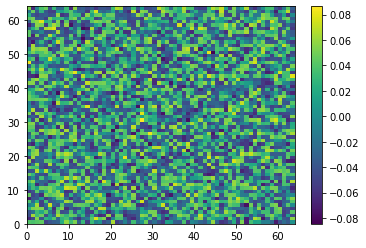

In [150]:
for i,n in zip(gen_imgs,z):
    print(f"Input to Generator: {n}")
    plt.pcolormesh(i[0].cpu().detach().numpy())
    plt.colorbar()
    plt.show()